In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple
from itertools   import count
from copy        import deepcopy
from PIL         import Image

import torch
import torch.nn               as nn
import torch.optim            as optim
import torch.nn.functional    as F
import torchvision.transforms as T

from torch.autograd import Variable

In [3]:
env = gym.make("Breakout-v0")
_ = env.reset()

In [4]:
class DQN(nn.Module): 
    def __init__(self):
        super(DQN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
        )

        self.sel = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.sel(out)

        return out

In [5]:
dqn = DQN().cuda()

In [6]:
print(dqn)

DQN(
  (cnn): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): LeakyReLU(0.01, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(0.01, inplace)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (sel): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): LeakyReLU(0.01, inplace)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [7]:
compose = T.Compose([T.ToPILImage(),
                     T.Grayscale(),
                     T.Resize((84, 84)),
                     T.ToTensor()])

In [8]:
def compile_screen(observation):
    screen = observation[35:195,10:150 ,:]
    screen = screen.transpose((2, 0, 1))  # транспонирование в порядок торча (СHW)

    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Ресайзим и добавляем батч размерность
    return compose(screen).unsqueeze(0).type(torch.cuda.FloatTensor)

In [9]:
obs = env.reset()
screen = compile_screen(obs)

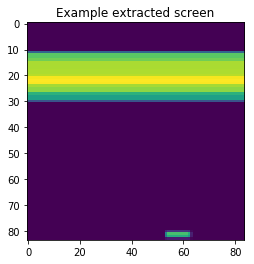

In [10]:
plt.figure()
screen = screen.cpu()[0].squeeze(0).squeeze(0)
plt.imshow(screen.numpy(), interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [11]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
EPISODES = 30000

In [12]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Положить переход в память."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """ Получить сэмпл из памяти """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
optimizer = optim.RMSprop(dqn.parameters())
memory = ReplayMemory(10000)

In [14]:
steps_done = 0

def dqn_action(screen, sampled=True):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY) if sampled else 0
    steps_done += 1
    
    if sample > eps_threshold:
        return dqn(Variable(screen, volatile=True).cuda()).data.max(1)[1].view(1, 1)
    else:
        return torch.cuda.LongTensor([[random.randrange(4)]])

In [15]:
episode_durations = []
avg_durations = []
last_sync = 0

In [16]:
def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.cuda.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

    # Блокируем прохождение градиента для вычисления функции ценности действия
    # volatile=True
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]), volatile=True)
    
    state_batch = Variable(torch.cat(batch.state)).cuda()
    action_batch = Variable(torch.cat(batch.action)).cuda()
    reward_batch = Variable(torch.cat(batch.reward)).cuda()

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колоки, которые соответствуют нашим действиям на щаге
    
    state_action_values = dqn(state_batch).gather(1, action_batch)
    
    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(torch.cuda.FloatTensor))
    next_state_values[non_final_mask] = dqn(non_final_next_states).max(1)[0] # берем значение максимума
    
    # Для подсчета лоса нам нужно будет разрешить прохождение градиента по переменной
    # блокировку, которого мы унаследовали
    # requires_grad=False
    next_state_values.volatile = False
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in dqn.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, t=0, episode=0, avg=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.title("Ep {0:4d}, time {1:4d}, avg {2:.1f}".format(episode, t, avg))
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
import pickle as pkl

num_episodes = EPISODES
for i_episode in range(num_episodes):
    # Инициализация среды
    obs = env.reset()
    
    screen = compile_screen(obs)
    
    current_screen = screen
    last_screen = screen
    
    inp = torch.zeros(1, 4, 84, 84).cuda()
    for i in range(4):
        inp[:, i:i+1, :, :] = screen
    
    state = inp
    
    for t in count():
        
        #show_state(env.env, t, i_episode)
        
        # Выбрать и выполнить нове действие
        action = dqn_action(state)
        obs, reward, done, _ = env.step(action[0][0])
        reward = torch.cuda.FloatTensor([reward])

        # Получаем новое состояние
        last_screen = current_screen
        current_screen = compile_screen(obs)
        if not done:
            next_state_s = current_screen
            tinp = torch.zeros(1, 4, 84, 84).cuda()
            tinp[:, :3, :, :]  = inp[:, 1:, :, :]
            tinp[:, 3:4, :, :] = next_state_s

            next_state = tinp
            inp = tinp
        else:
            next_state = None

        # Сохраняем состояние, следующее состояние, награду и действие в память
        memory.push(state, action, next_state, reward)

        # Переходим в новое состояние
        state = next_state

        # Шаг оптимизации 
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            if i_episode % 100 == 0:
                tdur = episode_durations[max(0, len(episode_durations) - 100):]
        
                avg_duration = sum(tdur)/len(tdur)
                avg_durations.append(avg_duration)
                print("Ep {0:6d}, avg {1:.2f}".format(i_episode + 1, avg_duration) )
                with open('dqn{0}.pkl'.format(i_episode), 'wb') as f:
                    pkl.dump(dqn, f)
        
            break

print('Complete')

Ep      1, avg 173.00
Ep    101, avg 267.71
Ep    201, avg 265.14
Ep    301, avg 299.44
Ep    401, avg 307.96
Ep    501, avg 303.63
Ep    601, avg 293.62
Ep    701, avg 301.51
Ep    801, avg 298.39
Ep    901, avg 302.09
Ep   1001, avg 328.62
Ep   1101, avg 286.39
Ep   1201, avg 337.86
Ep   1301, avg 299.89
Ep   1401, avg 284.60
Ep   1501, avg 298.33
Ep   1601, avg 310.28
Ep   1701, avg 288.74
Ep   1801, avg 286.72
Ep   1901, avg 292.11
Ep   2001, avg 300.37
Ep   2101, avg 290.19
Ep   2201, avg 340.48
Ep   2301, avg 336.70
Ep   2401, avg 355.79
Ep   2501, avg 333.28
Ep   2601, avg 336.40
Ep   2701, avg 267.70
Ep   2801, avg 319.98
Ep   2901, avg 271.24
Ep   3001, avg 312.36
Ep   3101, avg 332.25
Ep   3201, avg 310.73
Ep   3301, avg 302.55
Ep   3401, avg 292.88
Ep   3501, avg 277.91
Ep   3601, avg 294.24
Ep   3701, avg 296.15
Ep   3801, avg 304.79
Ep   3901, avg 316.05
Ep   4001, avg 309.46
Ep   4101, avg 300.73
Ep   4201, avg 319.17
Ep   4301, avg 288.64
Ep   4401, avg 290.24
Ep   4501,

In [ ]:
import pickle

with open('dqn.pkl', 'wb') as f:
    pickle.dump(dqn, f)

In [ ]:
with open("durations.pkl", "wb") as f:
    pickle.dump(avg_durations, f)